In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from datetime import datetime
from hts import HTSRegressor
import hts.functions
from hts.hierarchy import HierarchyTree
from sklearn.pipeline import Pipeline
import json
from random import sample
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
zri_df_og = pd.read_csv('../../data/HIER_zri_multifamily_v2.csv', dtype={'zip': str})

In [3]:
zri_df = zri_df_og.drop(['SizeRank', 'Metro'], axis=1)

In [4]:
zri_df = zri_df[(zri_df['State']=='IL') | (zri_df['State']=='CT') | (zri_df['State']=='FL')]
zri_df = zri_df.dropna()

In [5]:
zri_df['State_County'] = zri_df['State'] +\
                                        "_" + zri_df['CountyName']
zri_df['State_County_City'] = zri_df['State'] +\
                                        "_" + zri_df['CountyName'] +\
                                        "_" + zri_df['City']
zri_df['State_County_City_Zip'] = zri_df['State'] +\
                                        "_" + zri_df['CountyName'] +\
                                        "_" + zri_df['City'] +\
                                        "_" + zri_df['zip'] 
zri_df

,zip,City,State,CountyName,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,...,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,State_County,State_County_City,State_County_City_Zip
1,60657,Chicago,IL,Cook County,1647.0,1645.0,1635.0,1650.0,1660.0,1665.0,...,1787.0,1801.0,1806.0,1789.0,1761.0,1747.0,1731.0,IL_Cook County,IL_Cook County_Chicago,IL_Cook County_Chicago_60657
7,60640,Chicago,IL,Cook County,1371.0,1367.0,1357.0,1359.0,1358.0,1359.0,...,1506.0,1503.0,1498.0,1506.0,1494.0,1498.0,1497.0,IL_Cook County,IL_Cook County_Chicago,IL_Cook County_Chicago_60640
13,60647,Chicago,IL,Cook County,1429.0,1439.0,1443.0,1455.0,1452.0,1454.0,...,1671.0,1682.0,1685.0,1663.0,1621.0,1624.0,1579.0,IL_Cook County,IL_Cook County_Chicago,IL_Cook County_Chicago_60647
39,60613,Chicago,IL,Cook County,1617.0,1613.0,1608.0,1624.0,1629.0,1638.0,...,1738.0,1750.0,1755.0,1756.0,1704.0,1692.0,1681.0,IL_Cook County,IL_Cook County_Chicago,IL_Cook County_Chicago_60613
44,60625,Chicago,IL,Cook County,1394.0,1395.0,1407.0,1417.0,1420.0,1425.0,...,1546.0,1552.0,1555.0,1558.0,1551.0,1543.0,1533.0,IL_Cook County,IL_Cook County_Chicago,IL_Cook County_Chicago_60625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,06119,West Hartford,CT,Hartford County,1285.0,1281.0,1295.0,1305.0,1307.0,1308.0,...,1389.0,1396.0,1400.0,1399.0,1396.0,1402.0,1389.0,CT_Hartford County,CT_Hartford County_West Hartford,CT_Hartford County_West Hartford_06119
1257,33413,Greenacres,FL,Palm Beach County,1334.0,1334.0,1322.0,1313.0,1309.0,1310.0,...,1475.0,1479.0,1479.0,1462.0,1472.0,1467.0,1459.0,FL_Palm Beach County,FL_Palm Beach County_Greenacres,FL_Palm Beach County_Greenacres_33413
1265,06519,New Haven,CT,New Haven County,1134.0,1138.0,1142.0,1147.0,1144.0,1148.0,...,1230.0,1223.0,1225.0,1241.0,1258.0,1263.0,1263.0,CT_New Haven County,CT_New Haven County_New Haven,CT_New Haven County_New Haven_06519
1266,06418,Derby,CT,New Haven County,1129.0,1130.0,1128.0,1139.0,1146.0,1156.0,...,1233.0,1235.0,1236.0,1235.0,1234.0,1248.0,1252.0,CT_New Haven County,CT_New Haven County_Derby,CT_New Haven County_Derby_06418


In [6]:
# list(zri_df.columns)

In [7]:
zri_by_total = pd.DataFrame(zri_df[['2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06',
 '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03',
 '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
 '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09',
 '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
 '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03',
 '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
 '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09',
 '2019-10', '2019-11', '2019-12', '2020-01']].sum()).T
zri_by_total['Total']='total'
zri_by_total = zri_by_total.set_index('Total')

In [8]:
zri_by_state = zri_df.groupby(["State"]).sum()

In [9]:
zri_by_county = zri_df.groupby(["State_County"]).sum()

In [10]:
zri_by_city = zri_df.groupby(["State_County_City"]).sum()

In [11]:
zri_by_city

,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,...,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01
State_County_City,,,,,,,,,,,,,,,,,,,,,
CT_Fairfield County_Bridgeport,3676.0,3678.0,3688.0,3688.0,3673.0,3658.0,3665.0,3682.0,3694.0,3709.0,...,4088.0,4089.0,4099.0,4103.0,4100.0,4097.0,4088.0,4064.0,4064.0,4076.0
CT_Fairfield County_Danbury,1604.0,1604.0,1603.0,1596.0,1580.0,1574.0,1578.0,1572.0,1584.0,1589.0,...,1627.0,1643.0,1658.0,1666.0,1668.0,1672.0,1686.0,1705.0,1711.0,1747.0
CT_Fairfield County_Fairfield,1582.0,1560.0,1544.0,1539.0,1545.0,1534.0,1534.0,1530.0,1531.0,1550.0,...,1645.0,1650.0,1656.0,1677.0,1700.0,1715.0,1703.0,1701.0,1695.0,1706.0
CT_Fairfield County_Norwalk,3519.0,3503.0,3477.0,3429.0,3402.0,3398.0,3408.0,3425.0,3474.0,3496.0,...,3653.0,3670.0,3677.0,3696.0,3724.0,3768.0,3782.0,3784.0,3758.0,3693.0
CT_Fairfield County_Stratford,1258.0,1256.0,1273.0,1288.0,1300.0,1309.0,1314.0,1318.0,1324.0,1341.0,...,1465.0,1464.0,1470.0,1474.0,1463.0,1450.0,1439.0,1427.0,1449.0,1470.0
CT_Hartford County_Bristol,947.0,946.0,940.0,947.0,950.0,953.0,946.0,940.0,942.0,949.0,...,1050.0,1051.0,1053.0,1056.0,1057.0,1060.0,1069.0,1064.0,1074.0,1067.0
CT_Hartford County_Enfield,1137.0,1133.0,1135.0,1128.0,1125.0,1123.0,1130.0,1133.0,1140.0,1141.0,...,1220.0,1211.0,1204.0,1201.0,1197.0,1198.0,1228.0,1243.0,1249.0,1250.0
CT_Hartford County_Manchester,1057.0,1053.0,1050.0,1051.0,1053.0,1056.0,1063.0,1071.0,1079.0,1090.0,...,1176.0,1167.0,1164.0,1167.0,1171.0,1180.0,1201.0,1195.0,1195.0,1198.0
CT_Hartford County_West Hartford,1285.0,1281.0,1295.0,1305.0,1307.0,1308.0,1298.0,1287.0,1293.0,1297.0,...,1367.0,1370.0,1377.0,1389.0,1396.0,1400.0,1399.0,1396.0,1402.0,1389.0


In [12]:
df_dict_total={}
df_dict_total['total']=list(zri_df['State'].unique())

In [13]:
df_dict_states={}
for state in df_dict_total['total']:
    df_dict_states[state]=list(zri_df[zri_df['State']==state]['State_County'].unique())

In [14]:
df_dict_county={}
for state in df_dict_total['total']:
    for county in df_dict_states[state]:
        df_dict_county[county]=list(zri_df[zri_df['State_County']==county]['State_County_City'].unique())

In [15]:
df_dict_city={}
for state in df_dict_total['total']:
    for county in df_dict_states[state]:
        for city in df_dict_county[county]:
            df_dict_city[city]=list(zri_df[zri_df['State_County_City']==city]['State_County_City_Zip'].unique())

In [16]:
hierarchy = {**df_dict_total, **df_dict_states, **df_dict_county, **df_dict_city}

with open('../../data/processed/hierarchy.json', 'w') as j:
    json.dump(hierarchy, j)

In [17]:
zri_by_zip = zri_df.set_index('State_County_City_Zip')\
.drop(['zip', 'City', 'State', 'CountyName',
      'State_County', 'State_County_City'], axis=1)

In [18]:
all_zri = [zri_by_total, zri_by_state, zri_by_county, zri_by_city, zri_by_zip]
full_zri = pd.concat(all_zri).T
# full_zri

In [19]:
full_zri.index = pd.to_datetime(full_zri.index, format='%Y-%m')

In [20]:
full_zri

,total,CT,FL,IL,CT_Fairfield County,CT_Hartford County,CT_Middlesex County,CT_New Haven County,FL_Broward County,FL_Duval County,...,CT_Fairfield County_Bridgeport_06610,IL_Cook County_Chicago_60661,CT_Fairfield County_Fairfield_06825,CT_Fairfield County_Stratford_06615,CT_New Haven County_Ansonia_06401,CT_Hartford County_West Hartford_06119,FL_Palm Beach County_Greenacres_33413,CT_New Haven County_New Haven_06519,CT_New Haven County_Derby_06418,IL_Cook County_Chicago_60606
2014-01-01,115967.0,30473.0,50848.0,34646.0,11639.0,4426.0,1150.0,13258.0,9327.0,2004.0,...,1190.0,1949.0,1582.0,1258.0,1113.0,1285.0,1334.0,1134.0,1129.0,2004.0
2014-02-01,115920.0,30424.0,50917.0,34579.0,11601.0,4413.0,1152.0,13258.0,9342.0,2010.0,...,1192.0,1945.0,1560.0,1256.0,1114.0,1281.0,1334.0,1138.0,1130.0,2001.0
2014-03-01,115891.0,30436.0,50924.0,34531.0,11585.0,4420.0,1149.0,13282.0,9360.0,2023.0,...,1195.0,1945.0,1544.0,1273.0,1115.0,1295.0,1322.0,1142.0,1128.0,2016.0
2014-04-01,116010.0,30442.0,50855.0,34713.0,11540.0,4431.0,1151.0,13320.0,9332.0,2035.0,...,1196.0,1956.0,1539.0,1288.0,1113.0,1305.0,1313.0,1147.0,1139.0,2041.0
2014-05-01,116096.0,30465.0,50847.0,34784.0,11500.0,4435.0,1154.0,13376.0,9321.0,2047.0,...,1190.0,1966.0,1545.0,1300.0,1117.0,1307.0,1309.0,1144.0,1146.0,2066.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-01,132199.0,33464.0,60527.0,38208.0,12702.0,4838.0,1279.0,14645.0,10821.0,2535.0,...,1314.0,2149.0,1715.0,1450.0,1243.0,1400.0,1479.0,1225.0,1236.0,2228.0
2019-10-01,132306.0,33524.0,60624.0,38158.0,12698.0,4897.0,1265.0,14664.0,10862.0,2546.0,...,1317.0,2094.0,1703.0,1439.0,1251.0,1399.0,1462.0,1241.0,1235.0,2217.0
2019-11-01,132198.0,33523.0,60633.0,38042.0,12681.0,4898.0,1261.0,14683.0,10891.0,2593.0,...,1309.0,2103.0,1701.0,1427.0,1253.0,1396.0,1472.0,1258.0,1234.0,2230.0
2019-12-01,132244.0,33519.0,60788.0,37937.0,12677.0,4920.0,1242.0,14680.0,10822.0,2591.0,...,1305.0,2082.0,1695.0,1449.0,1252.0,1402.0,1467.0,1263.0,1248.0,2200.0


In [21]:
samp = sample(list(full_zri.columns), 10)

In [37]:
tree = HierarchyTree.from_nodes(hierarchy, full_zri, root='total')

In [38]:
print(tree)

- total
   |- IL
   |  |- IL_Cook County
   |  |  - IL_Cook County_Chicago
   |  |     |- IL_Cook County_Chicago_60657
   |  |     |- IL_Cook County_Chicago_60640
   |  |     |- IL_Cook County_Chicago_60647
   |  |     |- IL_Cook County_Chicago_60613
   |  |     |- IL_Cook County_Chicago_60625
   |  |     |- IL_Cook County_Chicago_60610
   |  |     |- IL_Cook County_Chicago_60619
   |  |     |- IL_Cook County_Chicago_60611
   |  |     |- IL_Cook County_Chicago_60620
   |  |     |- IL_Cook County_Chicago_60649
   |  |     |- IL_Cook County_Chicago_60626
   |  |     |- IL_Cook County_Chicago_60660
   |  |     |- IL_Cook County_Chicago_60637
   |  |     |- IL_Cook County_Chicago_60623
   |  |     |- IL_Cook County_Chicago_60609
   |  |     |- IL_Cook County_Chicago_60654
   |  |     |- IL_Cook County_Chicago_60651
   |  |     |- IL_Cook County_Chicago_60624
   |  |     |- IL_Cook County_Chicago_60621
   |  |     |- IL_Cook County_Chicago_60601
   |  |     |- IL_Cook County_Chicago_60642
 

### Predicting with SARIMAX

In [59]:
clf = HTSRegressor(model='sarimax', revision_method='OLS', n_jobs=12)
model = clf.fit(full_zri, hierarchy)



Fitting models:   0%|          | 0/52 [00:00<?, ?it/s]

Fitting models:   2%|▏         | 1/52 [00:09<08:09,  9.61s/it]

Fitting models:   6%|▌         | 3/52 [00:09<05:30,  6.74s/it]

Fitting models:  10%|▉         | 5/52 [00:09<03:42,  4.74s/it]

Fitting models:  12%|█▏        | 6/52 [00:10<02:34,  3.36s/it]

Fitting models:  13%|█▎        | 7/52 [00:10<01:47,  2.40s/it]

Fitting models:  15%|█▌        | 8/52 [00:10<01:15,  1.72s/it]

Fitting models:  17%|█▋        | 9/52 [00:10<00:54,  1.26s/it]

Fitting models:  19%|█▉        | 10/52 [00:10<00:39,  1.07it/s]

Fitting models:  21%|██        | 11/52 [00:10<00:28,  1.45it/s]

Fitting models:  23%|██▎       | 12/52 [00:11<00:22,  1.78it/s]

Fitting models:  25%|██▌       | 13/52 [00:11<00:19,  2.00it/s]

Fitting models:  31%|███       | 16/52 [00:11<00:13,  2.75it/s]

Fitting models:  35%|███▍      | 18/52 [00:11<00:09,  3.51it/s]

Fitting models:  38%|███▊      | 20/52 [00:12<00:07,  4.01it/s]

Fitting models:  40%|████      | 21/52 

In [60]:
preds = model.predict(steps_ahead=28)



Fitting models:   0%|          | 0/52 [00:00<?, ?it/s]

Fitting models:   2%|▏         | 1/52 [00:08<07:38,  8.99s/it]

Fitting models:  10%|▉         | 5/52 [00:09<04:56,  6.30s/it]

Fitting models:  13%|█▎        | 7/52 [00:09<03:19,  4.43s/it]

Fitting models:  17%|█▋        | 9/52 [00:09<02:13,  3.11s/it]

Fitting models:  35%|███▍      | 18/52 [00:09<01:14,  2.18s/it]

Fitting models:  44%|████▍     | 23/52 [00:09<00:44,  1.54s/it]

Fitting models:  52%|█████▏    | 27/52 [00:09<00:27,  1.08s/it]

Fitting models:  60%|█████▉    | 31/52 [00:09<00:16,  1.30it/s]

Fitting models:  67%|██████▋   | 35/52 [00:09<00:09,  1.82it/s]

Fitting models:  75%|███████▌  | 39/52 [00:10<00:05,  2.55it/s]

Fitting models:  83%|████████▎ | 43/52 [00:10<00:02,  3.51it/s]

Fitting models:  90%|█████████ | 47/52 [00:10<00:01,  4.75it/s]

Fitting models: 100%|██████████| 52/52 [00:10<00:00,  4.95it/s]


TypeError: cannot do slice indexing on DatetimeIndex with these indexers [[['FL_Pinellas County', "FL_Hillsborough County_Town 'n' Country_33615", 'CT_Fairfield County_Norwalk_06851', 'IL_Lake County', 'CT_Middlesex County_Middletown_06457', 'IL_Cook County_Chicago_60621', 'CT_Fairfield County', 'FL_Palm Beach County_Greenacres_33413', 'CT_Hartford County_West Hartford', 'CT_Hartford County_Manchester_06040']]] of type list

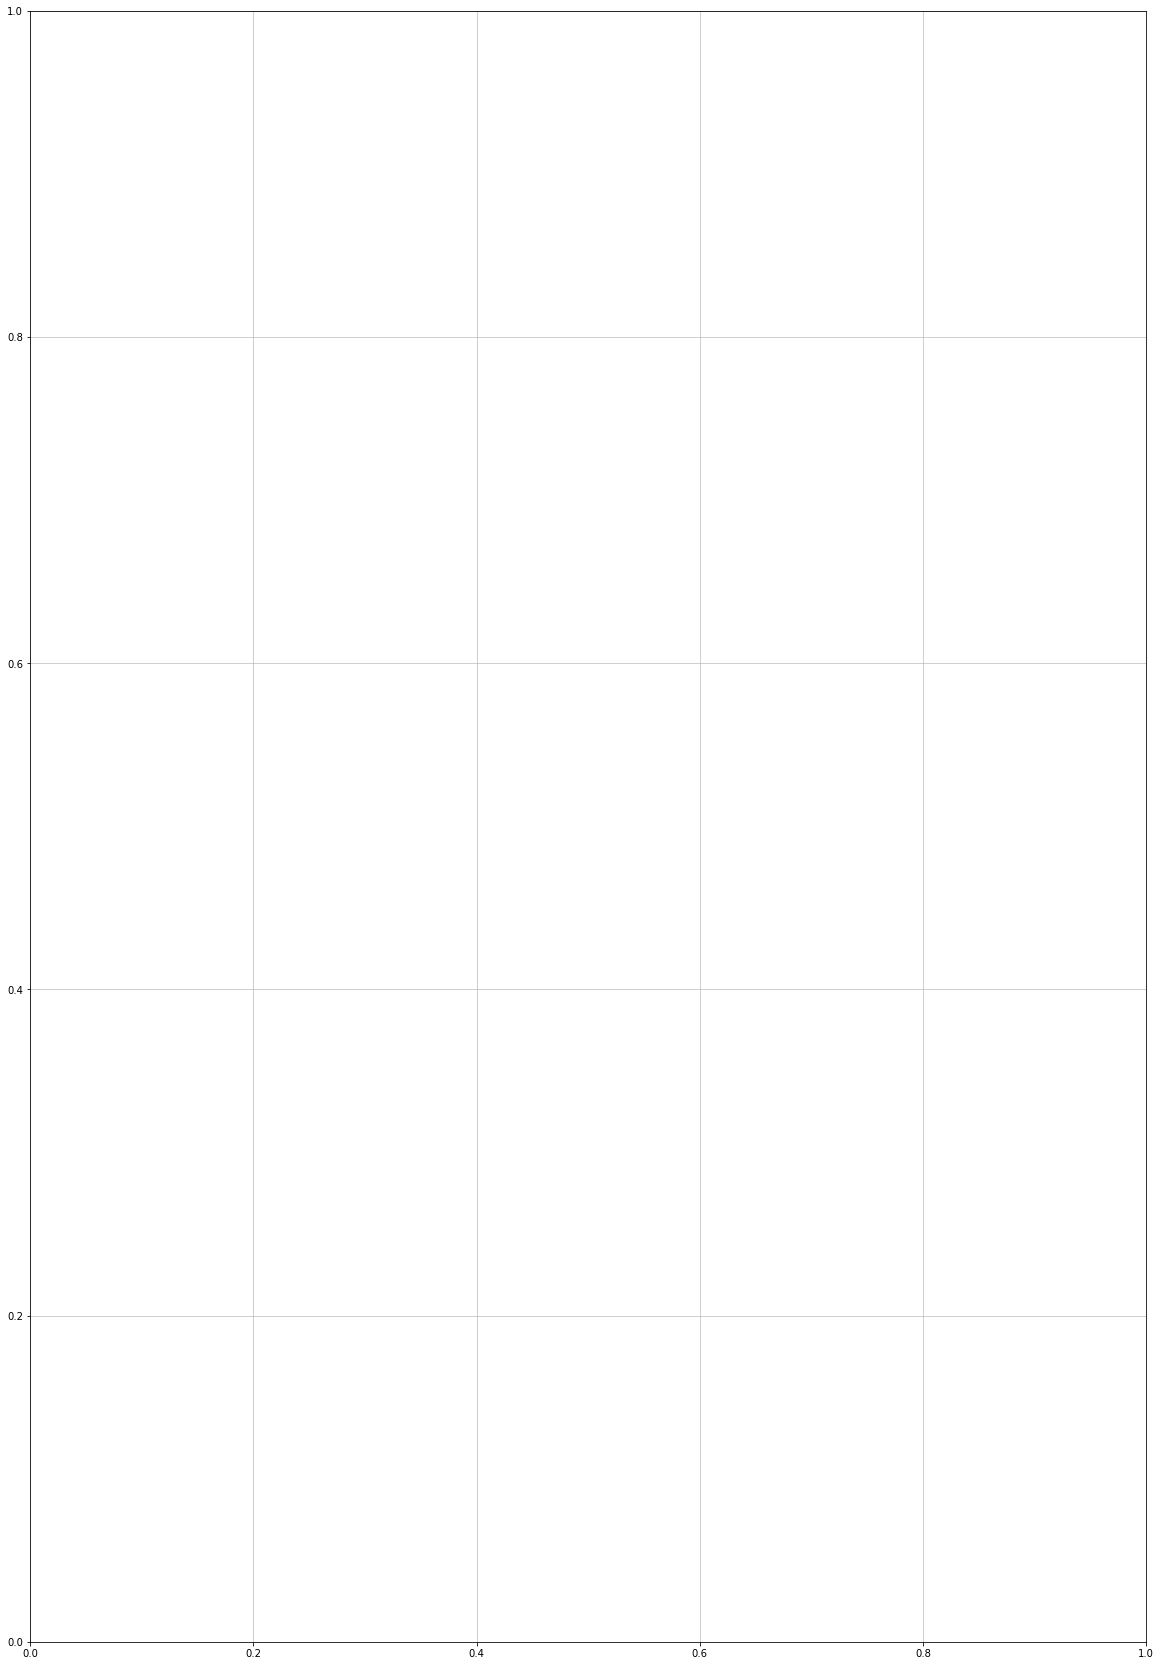

In [74]:
PLOT = [samp
       ]

fig, axs = plt.subplots(len(PLOT), figsize=(20, 30), sharex=True)
axs.grid(alpha=0.75)

dts = preds[PLOT_FROM:].index

for i, group in enumerate(PLOT):
    axs[i].plot(df[PLOT_FROM:][group], 
            lw=1.1, 
            color='#2ecc71', 
            alpha=0.8, 
            label='Truth')
    axs[i].plot(preds[PLOT_FROM:][group], 
            lw=1.1,
            color='#e74c3c', 
            alpha=0.8, 
            label='Prediction')
    axs[i].legend()
    axs[i].set_title('Prediction VS True series')

### Predicting with AUTO- ARIMA

In [22]:
clf = HTSRegressor(model='auto_arima', revision_method='OLS', n_jobs=0)
model = clf.fit(full_zri, hierarchy)

Fitting models: 100%|██████████| 156/156 [02:46<00:00,  1.07s/it]


In [23]:
predicted_autoarima = model.predict(steps_ahead=8)

Fitting models:   0%|          | 0/156 [00:00<?, ?it/s]/Users/backup/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/arima.py:577: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "
/Users/backup/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/arima.py:577: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "
/Users/backup/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/arima.py:577: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "
/Users/backup/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/arima.py:577: UserWarning: As of version 1.5.0

In [32]:
predicted_autoarima['CT_New Haven County_New Haven_06511']

2014-01-01     -28.907853
2014-02-01   -2302.288758
2014-03-01   -2248.450105
2014-04-01   -2233.322410
2014-05-01   -2227.319567
                 ...     
2020-01-05   -2763.996632
2020-01-06   -2769.125706
2020-01-07   -2774.380670
2020-01-08   -2778.422797
2020-01-09   -2781.979328
Name: CT_New Haven County_New Haven_06511, Length: 81, dtype: float64

In [33]:
full_zri['CT_New Haven County_New Haven_06511']

2014-01-01    1151.0
2014-02-01    1152.0
2014-03-01    1160.0
2014-04-01    1167.0
2014-05-01    1172.0
               ...  
2019-09-01    1269.0
2019-10-01    1285.0
2019-11-01    1280.0
2019-12-01    1268.0
2020-01-01    1263.0
Name: CT_New Haven County_New Haven_06511, Length: 73, dtype: float64

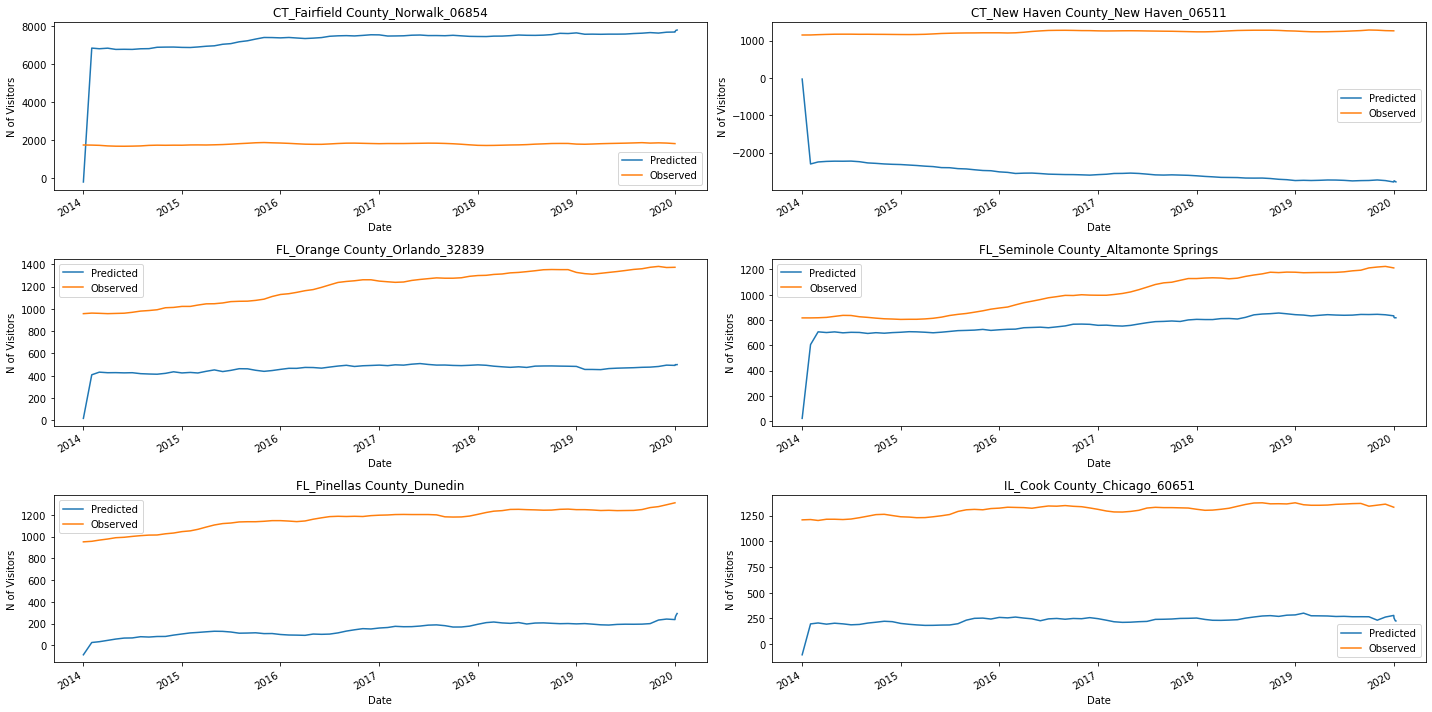

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(20, 10))

def plot_results(samp, axes, preds):
    axes = np.hstack(axes)
    for ax, samp in zip(axes, samp):
        preds[samp].plot(ax=ax, label="Predicted")
        full_zri[samp].plot(ax=ax, label="Observed")

        ax.legend()
        ax.set_title(samp)
        ax.set_xlabel("Date")
        ax.set_ylabel("N of Visitors")
    
plot_results(samp, axes, predicted_autoarima)
plt.tight_layout()

In [ ]:
print(f'Node: {ht.children[0].children[2].children[2].key}, item: ')
ht.children[0].children[2].children[2].item

In [111]:
grouped_sections = zri_df.groupby(["State", "State_County", 
                                   "State_County_City", "State_County_City_Zip"])
edges_hierarchy = list(grouped_sections.groups.keys())
edges_hierarchy[:20]

[('AK',
  'AK_Anchorage Borough',
  'AK_Anchorage Borough_Anchorage',
  'AK_Anchorage Borough_Anchorage_99501'),
 ('AK',
  'AK_Anchorage Borough',
  'AK_Anchorage Borough_Anchorage',
  'AK_Anchorage Borough_Anchorage_99504'),
 ('AK',
  'AK_Anchorage Borough',
  'AK_Anchorage Borough_Anchorage',
  'AK_Anchorage Borough_Anchorage_99508'),
 ('AK',
  'AK_Matanuska Susitna Borough',
  'AK_Matanuska Susitna Borough_Wasilla',
  'AK_Matanuska Susitna Borough_Wasilla_99654'),
 ('AR',
  'AR_Benton County',
  'AR_Benton County_Bentonville',
  'AR_Benton County_Bentonville_72712'),
 ('AR',
  'AR_Pulaski County',
  'AR_Pulaski County_Little Rock',
  'AR_Pulaski County_Little Rock_72205'),
 ('AR',
  'AR_Washington County',
  'AR_Washington County_Springdale',
  'AR_Washington County_Springdale_72764'),
 ('AZ',
  'AZ_Maricopa County',
  'AZ_Maricopa County_Chandler',
  'AZ_Maricopa County_Chandler_85224'),
 ('AZ',
  'AZ_Maricopa County',
  'AZ_Maricopa County_Mesa',
  'AZ_Maricopa County_Mesa_85201')

In [25]:
states = list(zri_df.State.unique())

In [26]:
second_level_nodes = states
root_node = "total"

root_edges = [(root_node, second_level_node) for second_level_node in second_level_nodes]
# root_edges

In [27]:
root_edges += edges_hierarchy

In [20]:
tree = HierarchyTree.from_nodes(root_edges, zri_df, root='total')
print(tree)

KeyError: "None of [Index(['total'], dtype='object')] are in the [columns]"

In [21]:
zri_df

,zip,City,State,Metro,CountyName,year-month,zri
0,1013,Chicopee,MA,Springfield,Hampden County,2014-01,928.0
1,1013,Chicopee,MA,Springfield,Hampden County,2014-02,931.0
2,1013,Chicopee,MA,Springfield,Hampden County,2014-03,934.0
3,1013,Chicopee,MA,Springfield,Hampden County,2014-04,929.0
4,1013,Chicopee,MA,Springfield,Hampden County,2014-05,929.0
...,...,...,...,...,...,...,...
93739,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-08,1277.0
93740,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-09,1271.0
93741,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-10,1299.0
93742,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-11,1261.5


In [17]:
Xn, Yn, Xe, Ye, labels, annot = get_nodes_edges_position(root_edges, root="total")
M = max(Yn)

fig = go.Figure()

fig.add_trace(go.Scatter(x=Xe,
                   y=Ye,
                   mode='lines',
                   line=dict(color='rgb(210,210,210)', width=1),
                   hoverinfo='none'
                   ))

fig.add_trace(go.Scatter(x=Xn,
                  y=Yn,
                  mode='markers',
                  name='bla',
                  marker=dict(symbol='circle-dot',
                                size=30,
                                color='#6175c1',    #'#DB4551',
                                line=dict(color='rgb(50,50,50)', width=1)
                                ),
                  text=labels,
                  hoverinfo='text',
                  opacity=0.8
                  ))

axis = dict(showline=False, # hide axis line, grid, ticklabels and  title
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            )

fig.update_layout(title= 'Hierarchical Structure Tree for Australian Tourism Data',
              annotations=annot,
              font_size=10,
              showlegend=False,
              xaxis=axis,
              yaxis=axis,
              margin=dict(l=40, r=40, b=85, t=100),
              hovermode='closest',
              plot_bgcolor='rgb(248,248,248)'
              )
fig.show()

NameError: name 'get_nodes_edges_position' is not defined

In [55]:
idx = pd.MultiIndex.from_product([['python', 'cobra'],
                                   [2018, 2019]])
idx


MultiIndex([('python', 2018),
            ('python', 2019),
            ( 'cobra', 2018),
            ( 'cobra', 2019)],
           )

In [56]:

idx.set_names(['kind', 'year'], inplace=True)
idx


MultiIndex([('python', 2018),
            ('python', 2019),
            ( 'cobra', 2018),
            ( 'cobra', 2019)],
           names=['kind', 'year'])

In [57]:
idx.set_names('species', level=0)


MultiIndex([('python', 2018),
            ('python', 2019),
            ( 'cobra', 2018),
            ( 'cobra', 2019)],
           names=['species', 'year'])